SIMO FODJO WELL YOHAN NATHAN

NAIVE BAYES

1. Importation des bibliothèques et chargement des données

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

Vue que nous avons déjà nettoyé les données dans DecisionTree.ipynb nous allons juste importer le dataset déjà nettoyé

In [ ]:
# Chargement des données
data = pd.read_csv('../data/clean_data.csv')

In [3]:
data.fillna(data.mean(), inplace=True)

2. Exploration des données

In [4]:
# Séparation des features et de la cible
X = data.drop('target', axis=1)
y = data['target']

In [5]:
# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

2. Modélisation avec Naive Bayes

In [6]:
# Création et entraînement du modèle
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [7]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f"Score d'entrainnement: {train_score}\nScore de teste :{test_score}")

Score d'entrainnement: 0.837874659400545
Score de teste :0.8695652173913043


In [8]:
pipeline = make_pipeline(StandardScaler(), GaussianNB())

In [9]:
# Entraînement du modèle
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gaussiannb', GaussianNB())])

In [10]:

# Évaluation sur l'ensemble de test
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

In [11]:
# Scores
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print(f"Score sur l'ensemble d'entraînement: {train_score:.2f}")
print(f"Score sur l'ensemble de test: {test_score:.2f}")
print("\nRapport de classification:\n", classification_report(y_test, y_pred))

Score sur l'ensemble d'entraînement: 0.84
Score sur l'ensemble de test: 0.87

Rapport de classification:
               precision    recall  f1-score   support

           0       0.89      0.80      0.85        82
           1       0.85      0.92      0.89       102

    accuracy                           0.87       184
   macro avg       0.87      0.86      0.87       184
weighted avg       0.87      0.87      0.87       184



3. Validation croisée

In [12]:
# Validation croisée
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10)
print(f"Scores de validation croisée: {cv_scores}")
print(f"Moyenne des scores de validation croisée: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

Scores de validation croisée: [0.86486486 0.89189189 0.7972973  0.85135135 0.80821918 0.83561644
 0.83561644 0.84931507 0.78082192 0.78082192]
Moyenne des scores de validation croisée: 0.83 ± 0.04


4. Courbe de validation

In [13]:
# Courbe de validation pour DecisionTreeClassifier
param_range = range(1, 21)
train_scores, test_scores = validation_curve(
    GaussianNB(), X_train, y_train, 
    param_name="var_smoothing", param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=-1
)

In [14]:
# Calcul des moyennes et écarts-types
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

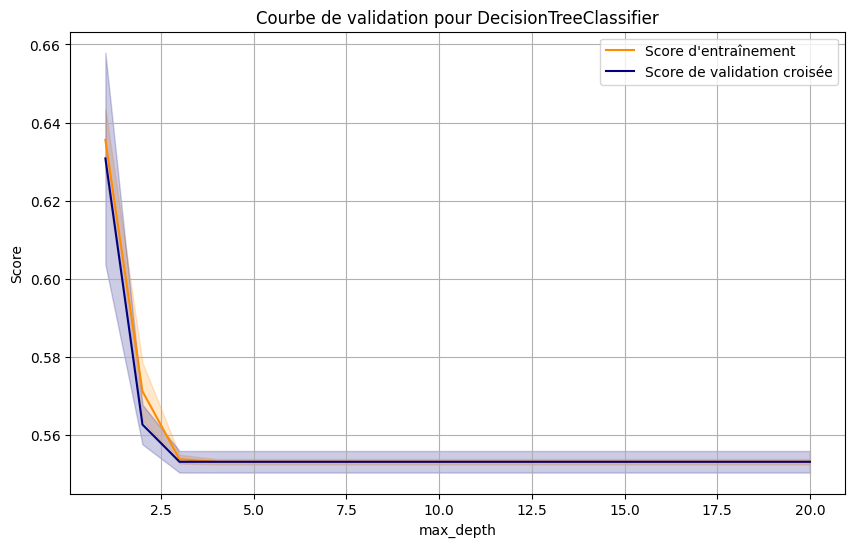

In [15]:
# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Score d'entraînement", color="darkorange")
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="darkorange")
plt.plot(param_range, test_mean, label="Score de validation croisée", color="navy")
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.2, color="navy")
plt.title("Courbe de validation pour DecisionTreeClassifier")
plt.xlabel("max_depth")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.show()

5. Optimisation avec GridSearchCV

In [16]:
param_grid = {
    'gaussiannb__var_smoothing' : [1e-9, 1e-6]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Meilleurs paramètres: {grid_search.best_params_}")
print(f"Meilleur score: {grid_search.best_score_:.2f}")

Meilleurs paramètres: {'gaussiannb__var_smoothing': 1e-09}
Meilleur score: 0.83


In [17]:
# Evaluation sur le test set
y_pred = grid_search.predict(X_test)
print(f"\nAccuracy sur le test set: {accuracy_score(y_test, y_pred):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy sur le test set: 0.870

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.85        82
           1       0.85      0.92      0.89       102

    accuracy                           0.87       184
   macro avg       0.87      0.86      0.87       184
weighted avg       0.87      0.87      0.87       184



6. Matrice de confusion

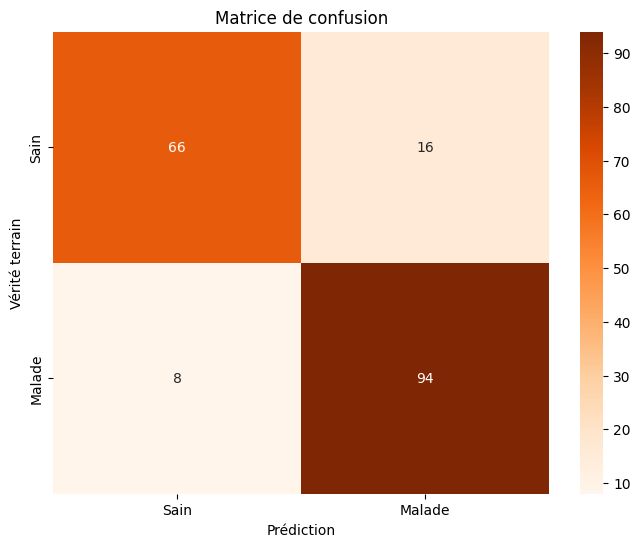

In [18]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['Sain', 'Malade'], 
            yticklabels=['Sain', 'Malade'])
plt.title('Matrice de confusion')
plt.ylabel('Vérité terrain')
plt.xlabel('Prédiction')
plt.show()

7. Courbe ROC

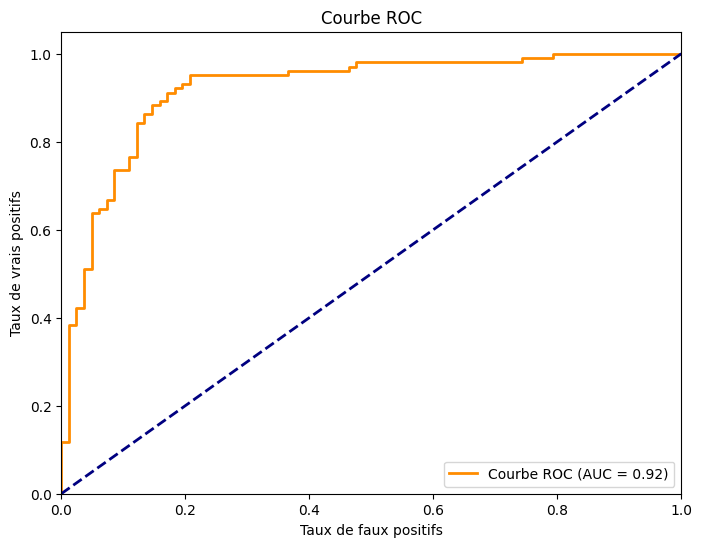

In [19]:
# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

8. Courbe d'apprentissage

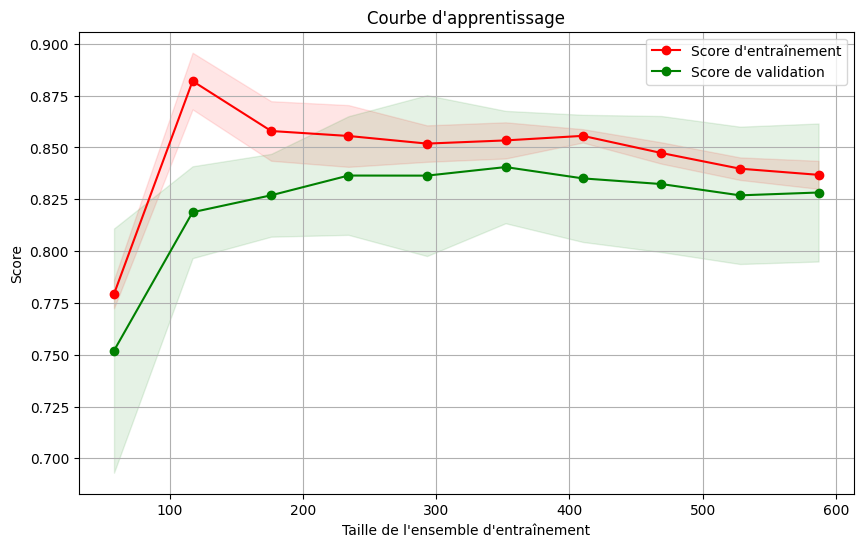

In [20]:
# Courbe d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(
    pipeline, X_train, y_train, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Score d'entraînement")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Score de validation")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Score")
plt.title("Courbe d'apprentissage")
plt.legend(loc="best")
plt.grid()
plt.show()

10. Sauvegarde du modele avec joblib

In [ ]:
# Sauvegarde du meilleur modèle
best_model = grid_search.best_estimator_
joblib.dump(best_model, 'heart_model_pipeline_naive_bayes.joblib')
print("Modèle sauvegardé sous 'heart_model_pipeline_naive_bayes.joblib'")

Modèle sauvegardé sous 'heart_model_pipeline_naive_bayes.joblib'


In [ ]:
# Sauvegarde des noms de colonnes pour Streamlit
feature_names = list(X.columns)
joblib.dump(feature_names, 'feature_names_naive_bayes.joblib')

['./models/feature_names_naive_bayes.joblib']